In [26]:
import pandas as pd
import numpy as np

import nltk
import re 
from nltk.tokenize import RegexpTokenizer

import seaborn as sns
import matplotlib.pyplot as plt

In [27]:
# Load data
df_people = pd.read_csv('..\\datasets\\1. Original Dataset\\people.csv')

In [28]:
df_people.head()

,id,Age,Gender,Education Level,Job Title,Years of Experience
0,0,32.0,Male,Bachelor's,Software Engineer,5.0
1,1,28.0,Female,Master's,Data Analyst,3.0
2,2,45.0,Male,PhD,Senior Manager,15.0
3,3,36.0,Female,Bachelor's,Sales Associate,7.0
4,4,52.0,Male,Master's,Director,20.0


In [29]:
# Load stopwords
stopwords = nltk.corpus.stopwords.words('english') 

In [30]:
def process_job_title(job_title):    
    if pd.isna(job_title):
        return []  # desctiption empty
    
    # Cleaning  (if desctiption not null)
    # Remove special characters and convert to lower case.
    job_title = re.sub("[^a-zA-Z]", " ", str(job_title)).lower()

    # Tokenize the job title
    tokenizer = RegexpTokenizer(r'\w+')
    job_title = tokenizer.tokenize(job_title)
    
    # Eliminate las stopwords (shoudn't be any)
    job_title = [word for word in job_title if word not in stopwords]
    
    return job_title


In [31]:
df_people['job_title_descriptions'] = df_people['Job Title'].apply(process_job_title)

In [32]:
df_people.head()

,id,Age,Gender,Education Level,Job Title,Years of Experience,job_title_descriptions
0,0,32.0,Male,Bachelor's,Software Engineer,5.0,"[software, engineer]"
1,1,28.0,Female,Master's,Data Analyst,3.0,"[data, analyst]"
2,2,45.0,Male,PhD,Senior Manager,15.0,"[senior, manager]"
3,3,36.0,Female,Bachelor's,Sales Associate,7.0,"[sales, associate]"
4,4,52.0,Male,Master's,Director,20.0,[director]


---
# Categorical Variables

In [33]:
from collections import Counter

# Flatten the list of lists and count occurrences
word_counts = Counter(word for words in df_people['job_title_descriptions'] for word in words)

# Convert to DataFrame (optional)
word_counts_df = pd.DataFrame(word_counts.items(), columns=['Word', 'Count']).sort_values(by='Count', ascending=False)

print(word_counts_df)

word_counts_df.to_csv("..\\datasets\\2. Processed Dataset\\job_titles.csv", index=False)

          Word  Count
4       senior    151
5      manager     96
30      junior     90
3      analyst     68
9    marketing     67
..         ...    ...
36      writer      1
47        help      1
48        desk      1
63  technology      1
41     network      1

[81 rows x 2 columns]


For this specific case, considering time limitations and efficiency, I leveraged ChatGPT to classify seniority levels and job categories. Otherwise, I would have implemented a machine learning approach, such as logistic regression, decision trees, or transformer-based NLP models like BERT or RoBERTa, for more precise classification.

In [34]:
# Define keywords for classification
seniority_levels = {
    "Junior": ["intern", "junior", "entry"],
    "Semi Senior": ["associate", "specialist", "coordinator", "executive"],
    "Senior": ["senior", "lead", "principal", "manager", "head"],
    "Director/Executive": ["director", "vp", "chief", "c-level","ceo", "cto", "cfo", "coo", "president"]
}

job_categories = {
    "Engineering": ["engineer", "developer", "software", "data", "architect","it"],
    "Marketing": ["marketing", "brand", "advertising", "social", "content"],
    "Sales": ["sales", "account", "business", "customer", "representative"],
    "Finance": ["finance", "accountant", "financial"],
    "HR": ["hr", "recruiter", "human", "talent"],
    "Operations": ["operations", "supply", "logistics", "project"],
    "Support": ["support", "customer", "service", "helpdesk"],
    "Design": ["designer", "ux", "graphic"],
    "Writing": ["writer", "copywriter", "editor"],
}

# Function to classify a job title containing multiple words
def classify_job_title(words):
    seniority = "Other"
    category = "Other"
    
    # Check if any word matches a seniority level
    for word in words:
        for level, keywords in seniority_levels.items():
            if word in keywords:
                seniority = level
                break
        if seniority != "Other":  # Stop checking once a match is found beacouse if not, the value is replace by onther seniority category
            break  
    
    # Check if any word matches a job category
    for word in words:
        for cat, keywords in job_categories.items():
            if word in keywords:
                category = cat
                break
    
    return seniority, category

# Apply classification
df_people[['Seniority', 'Job Category']] = df_people['job_title_descriptions'].apply(lambda x: pd.Series(classify_job_title(x)))

# Display results
df_people

,id,Age,Gender,Education Level,Job Title,Years of Experience,job_title_descriptions,Seniority,Job Category
0,0,32.0,Male,Bachelor's,Software Engineer,5.0,"[software, engineer]",Other,Engineering
1,1,28.0,Female,Master's,Data Analyst,3.0,"[data, analyst]",Other,Engineering
2,2,45.0,Male,PhD,Senior Manager,15.0,"[senior, manager]",Senior,Other
3,3,36.0,Female,Bachelor's,Sales Associate,7.0,"[sales, associate]",Semi Senior,Sales
4,4,52.0,Male,Master's,Director,20.0,[director],Director/Executive,Other
...,...,...,...,...,...,...,...,...,...
370,370,35.0,Female,Bachelor's,Senior Marketing Analyst,8.0,"[senior, marketing, analyst]",Senior,Marketing
371,371,43.0,Male,Master's,Director of Operations,19.0,"[director, operations]",Director/Executive,Operations
372,372,29.0,Female,Bachelor's,Junior Project Manager,2.0,"[junior, project, manager]",Junior,Operations
373,373,34.0,Male,Bachelor's,Senior Operations Coordinator,7.0,"[senior, operations, coordinator]",Senior,Operations


In [35]:
# Assign ordinal values
seniority_mapping = {
    "Junior": 1,
    "Semi Senior": 2,
    "Senior": 3,
    "Director/Executive": 4,
    "Other": -1
}


# Map the seniority levels to ordinal values
df_people["Seniority Level"] = df_people["Seniority"].map(seniority_mapping)

# Drop rows where seniority is still NaN (if necessary)
df = df_people.dropna(subset=["Seniority Level", "Years of Experience"])

# Compute correlation between Seniority Level and Years of Experience
correlation = df["Seniority Level"].corr(df["Years of Experience"])

print(f"Correlation between Seniority Level and Years of Experience: {correlation:.2f}")


Correlation between Seniority Level and Years of Experience: 0.61


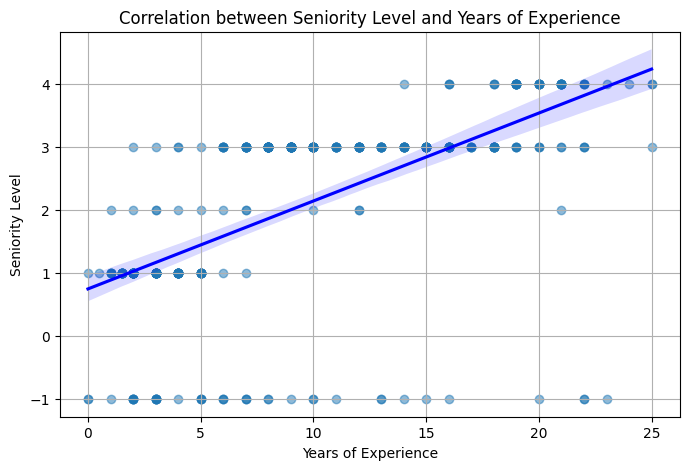

In [ ]:
# Plot correlation scatterplot with regression line
plt.figure(figsize=(8, 5))
sns.regplot(x="Years of Experience", y="Seniority Level", data=df_people, scatter_kws={"alpha":0.5}, line_kws={"color":"blue"})

# Titles and labels
plt.title("Correlation between Seniority Level and Years of Experience")
plt.xlabel("Years of Experience")
plt.ylabel("Seniority Level")
plt.grid(True)

# Show plot
plt.show()

In [37]:
df_people.to_csv("..\\datasets\\2. Processed Dataset\\people.csv", index=False)